# HGCAL FE studies

### imports and initial setup

In [58]:
#imports and setup

%matplotlib inline
%cd /home/naodell/work/hgcal

import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from descartes import PolygonPatch
from tqdm import tqdm_notebook

from skhep.modeling import bayesian_blocks
import scripts.helpers as hlp
import scripts.readout_algorithms as algos

import matplotlib
matplotlib.rcParams.update({'font.size': 16})

/home/naodell/work/hgcal


### get the data mixtures

In the script `**.py`, I make mixtures of signal and pileup samples.  

In [67]:
gen_list = []
df_list = []
inputdir = 'data/mc_mixtures/single_electron_pt35_skim_20180328_154138'
for filename in os.listdir(inputdir):
    data_file = open(f'{inputdir}/{filename}', 'rb')
    gen_list.extend(pickle.load(data_file))
    df_list.extend(pickle.load(data_file))
    data_file.close()

algo_list = ['baseline', 
             'threshold_1bx_esort',  'threshold_1bx_nosort', 
             'threshold_8bx_esort',  'threshold_8bx_nosort'
            ]
mippt_scan = np.arange(0, 10, 1)
ratios = {n:{mippt:[] for mippt in mippt_scan} for n in algo_list}
columns = ['reco_e', 'sim_e', 'pt']
cell_labels = ['zside', 'layer', 'sector', 'panel']
data_iter = list(zip(gen_list, df_list))
for gpart, data in tqdm_notebook(data_iter, total=len(data_iter)):
    gen1 = gpart.iloc[0]
    gen2 = gpart.iloc[1]
    denom = gen1.pt
    
    # carry out baseline selection
    df = data.query('sim_e > 0')
    for algo in algo_list:
        for mippt in mippt_scan:
            if algo == 'baseline':
                df_sumpt = df.query(f'mip_pt > {mippt}').groupby('zside')['pt'].sum()+1 
            else:
                cond = data[f'{algo}_{mippt}'] == True
                df_sumpt = df[cond].groupby('zside')['pt'].sum() 
            r = df_sumpt/denom
            #print(algo, mippt, r.values)
            ratios[algo][mippt].append(r.values)
    
ratios = {a:{pt:np.concatenate(d) for pt, d in algo_data.items()} for a, algo_data in ratios.items()}

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

/home/naodell/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


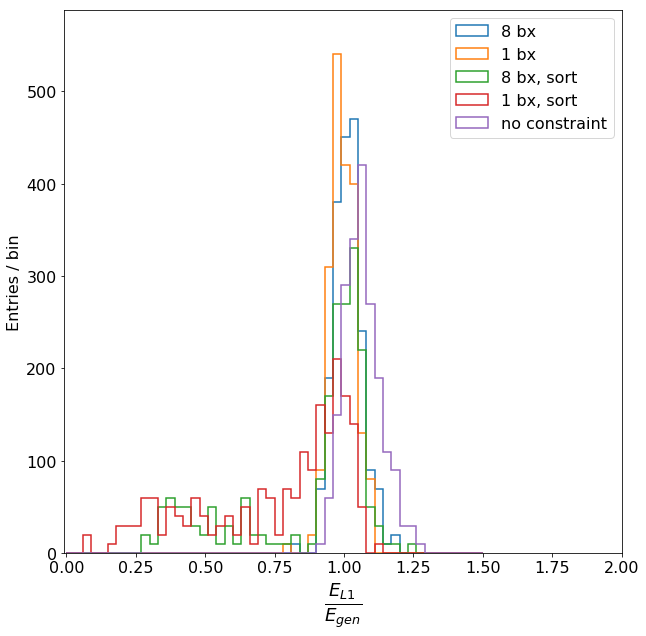

In [73]:
# mip_pt > 1 histograms

fig = plt.figure(figsize=(10, 10), facecolor='white')

ax = plt.subplot()
n_bins = 50
ax.hist(ratios['threshold_8bx_esort'][0], bins=n_bins, range=[0, 1.5], linewidth=1.5, histtype='step')
ax.hist(ratios['threshold_1bx_esort'][0], bins=n_bins, range=[0, 1.5], linewidth=1.5, histtype='step')
ax.hist(ratios['threshold_8bx_nosort'][0], bins=n_bins, range=[0, 1.5], linewidth=1.5, histtype='step')
ax.hist(ratios['threshold_1bx_nosort'][0], bins=n_bins, range=[0, 1.5], linewidth=1.5, histtype='step')
h, b, _ = ax.hist(ratios['baseline'][0], bins=n_bins, range=[0, 1.5], linewidth=1.5, histtype='step')

ax.set_xlim(-0.01, 2.)
ax.set_ylim(0, 1.4*np.max(h))
#ax.set_xlabel(r'$\frac{p_{T,L1}}{p_{T,gen}}$', fontsize=26)
ax.set_xlabel(r'$\frac{E_{L1}}{E_{gen}}$', fontsize=26)
ax.set_ylabel('Entries / bin')

labels = ['8 bx, sort', '1 bx, sort', '8 bx', '1 bx', 'no constraint']
#labels = ['8 bx', '8 bx, sort', 'no constraint']
ax.legend(labels)

plt.savefig('plots/threshold_algo_resolution_e35.pdf')
plt.show()

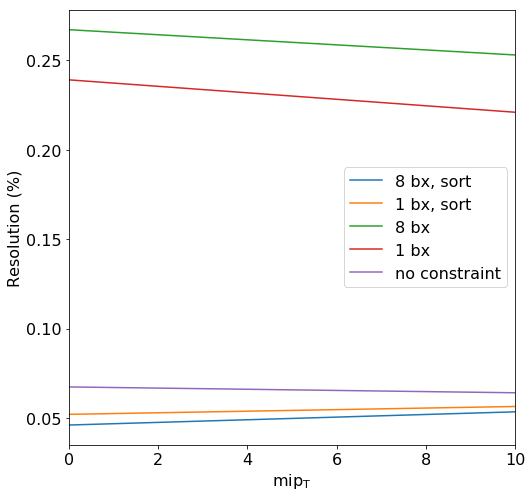

In [80]:
# mip_pt resolution scans
resolutions = {a:[d.std() for _, d in algo_data.items()] for a, algo_data in ratios.items()}

fig, ax = plt.subplots(1, 1, figsize=(8, 8), facecolor='white')
ax.plot(mippt_scan, resolutions['threshold_1bx_esort'])
ax.plot(mippt_scan, resolutions['threshold_8bx_esort'])
ax.plot(mippt_scan, resolutions['threshold_1bx_nosort'])
ax.plot(mippt_scan, resolutions['threshold_8bx_nosort'])
ax.plot(mippt_scan, resolutions['baseline'])

ax.set_xlim(0, 10)
ax.set_xlabel(r'$\sf mip_{T}$', fontsize=16)
ax.set_ylabel('Resolution (%)')

labels = ['8 bx, sort', '1 bx, sort', '8 bx', '1 bx', 'no constraint']
ax.legend(labels)

plt.show()